In [ ]:
import os
import torch
from torch import nn
import numpy as np
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from torchvision import transforms
import torchvision
import matplotlib.pyplot as plt

In [ ]:
# Set fixed random number seed
torch.manual_seed(42)

# Dataset Manipulation

The first thing we need to do is <font color=DeepPink>**load the dataset**</font>.

This will automatically download the training set for the **CIFAR10** dataset and save it in a folder called `data`. It will create the folder if it does not exist.

We transform them to Tensors of normalized range [-1, 1].

In [ ]:
# Hyperparameters
dataroot = 'data'
batch_size = 1024

# load dataset
transform = transforms.Compose([transforms.ToTensor()])
# transforms.ToTensor() can change the gray scale range from [0, 255] to [0, 1].

train_data = CIFAR10(dataroot, download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=1)

test_data = CIFAR10(dataroot, download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=1)

100%|██████████| 170498071/170498071 [00:01<00:00, 91267802.19it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


# Neural Network

Our model will be a neural network, specifically a multilayer perceptron (MLP) with two hidden layers.

Specifically, first we will flatten our 3x32x32 (3 color channel, 32 pixels height and width) image into a 3072 element vector, also called 3072 features. We flatten our input, as MLPs cannot handle two or three-dimensional data. Next, the 3072 dimensional input is passed through the first hidden layer to transform it into 1024 dimensions. Then, another hidden layer, which will transform it to 512 dimensions. Finally, an output layer which will transform it into a 10 dimensional vector. The output dimension should equal the number of classes within your data. Here we have ten categories, so need our output to be 10 dimensions.

```torch.nn.Linear()``` applies a linear transformation to the incoming data: $ y = xW^T+b $

Example: the input tensor ```x.shape=[10, 3072]```, where 10 is the batch size. We set two parameters of ```torch.nn.Linear()``` are 3072 and 1024, which means that ```W.shape=[1024, 3072]```, so the shape of $ W^T $ is ```W^T.shape=[3072, 1024]``` and the shape of $ b $ is ```b.shape=[1024]```. Using the formula, we can get $ y $ with the shape ```y.shape=[10, 1024]```.

In [ ]:
####### Write your deep neural network here #######
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim)
        )
    def forward(self, x):
        return self.layers(x)


In [ ]:
####### Initialize the model #######
input_dim = 32 * 32 * 3
output_dim = 10

model = MLP(input_dim, output_dim)
print(model)


MLP(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3072, out_features=1024, bias=True)
    (2): ReLU()
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): ReLU()
    (5): Linear(in_features=512, out_features=256, bias=True)
    (6): ReLU()
    (7): Linear(in_features=256, out_features=256, bias=True)
    (8): ReLU()
    (9): Linear(in_features=256, out_features=256, bias=True)
    (10): ReLU()
    (11): Linear(in_features=256, out_features=10, bias=True)
  )
)


This small function is created to calculate the number of trainable parameters (weights and biases) in MLP.

```torch.numel()``` returns the number of all elements in a tensor variable.

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 3,937,034 trainable parameters


In [ ]:
number = 3072 * 1024 + 1024 + 1024 * 512 + 512 + 512 * 10 + 10
print(number)

3676682


The first layer has 3072 input features connected to 1024 neurons, so 3072*1024 weighted connections plus 1024 bias terms.

The second layer has 1024 neurons connected to 512 neurons, 1024*512 weighted connections plus 512 bias terms.

The third layer has 512 neurons connected to 10 neurons, 100*10 weighted connections plus 10 bias terms.

 $$ Number = 3072 \times 1024 + 1024 + 1024 \times 512 + 512 + 512 \times 10 + 10 = 3676682 $$

# Train

In [ ]:
criterion = nn.CrossEntropyLoss() # define a loss function

In [ ]:
# Hyperparameters
lr = 0.01

optimizer = torch.optim.SGD(model.parameters(), lr=lr) # define a optimizer

In [ ]:
def train(trainloader, model, criterion, optimizer, device):
    # switch to train mode
    model.train()

    epoch_loss = []
    epoch_acc = []

    for i, (image, label) in enumerate(trainloader):
        image = image.to(device)
        label = label.to(device)

        # Forward pass
        output = model(image)

        # Compute loss
        loss = criterion(output, label)

        # measure accuracy
        acc = accuracy(output, label)

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss.append(loss.item())
        epoch_acc.append(acc.item())

    return sum(epoch_loss) / len(epoch_loss), sum(epoch_acc) / len(epoch_acc)



# Test

In [ ]:
def test(testloader, model, device):
    # switch to evaluate mode
    model.eval()

    epoch_acc = []

    with torch.no_grad():
        for i, (image, label) in enumerate(testloader):
            image = image.to(device)
            label = label.to(device)

            # Forward Pass
            output = model(image)

            acc = accuracy(output, label)

            epoch_acc.append(acc.item())

    return sum(epoch_acc) / len(epoch_acc)





# Evaluation

In [ ]:
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True) # pred: location index of the largest number in each batch
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res = correct_k.mul_(100.0 / batch_size)
        return res


# Plot

In [ ]:
def plot_loss_acc(train_loss, train_acc, test_acc):
    plot_x = np.arange(len(train_loss))

    plt.figure(figsize=(15, 7))

    plt.subplot(121)
    plt.plot(plot_x, train_loss)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['train_loss'])

    plt.subplot(122)
    plt.plot(plot_x, train_acc)
    plt.plot(plot_x, test_acc)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['train_acc', 'test_acc'])
    plt.show()

0 35.748016046018016
0 34.85790023803711


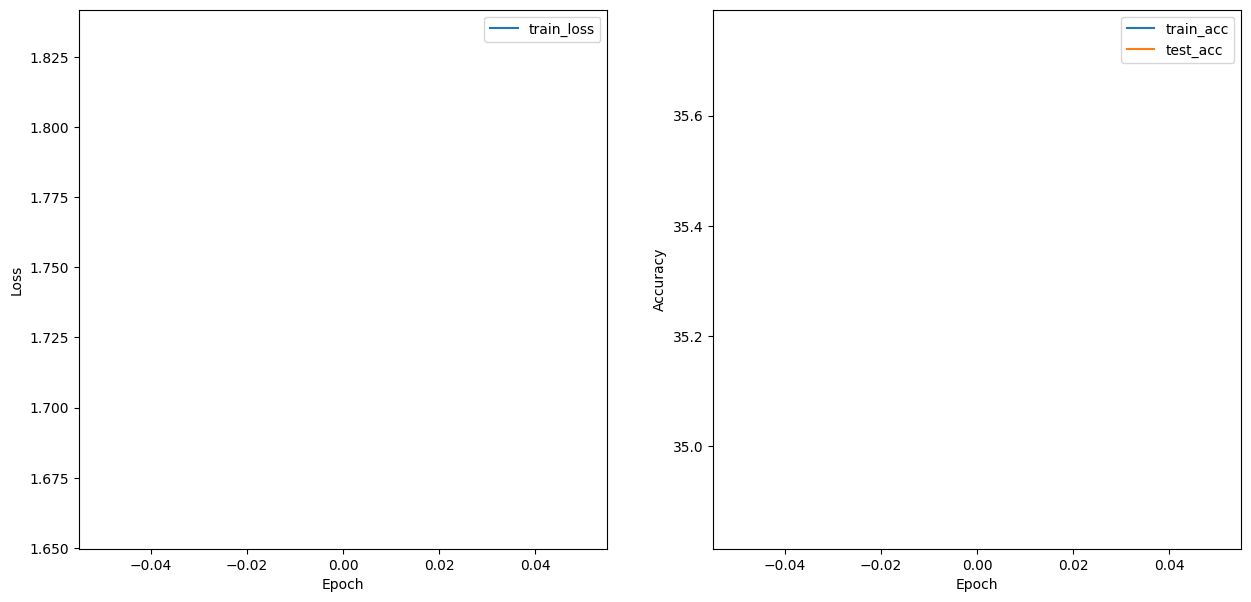

48 42.200059540417726
50 42.811104965209964


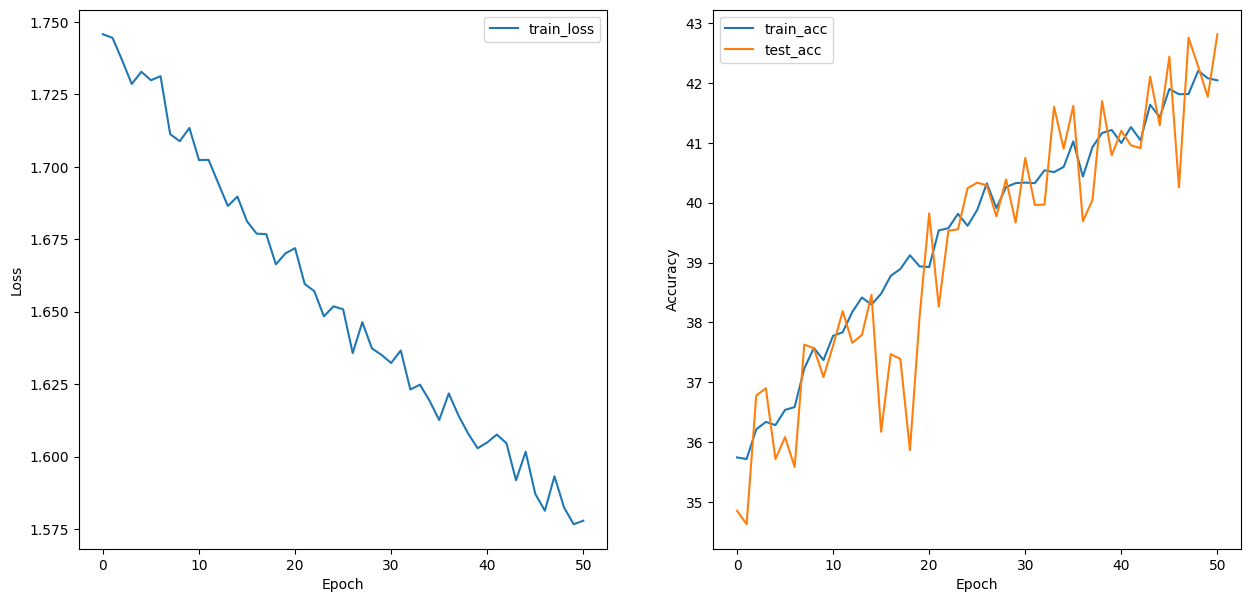

99 47.027406887132294
100 47.66183013916016


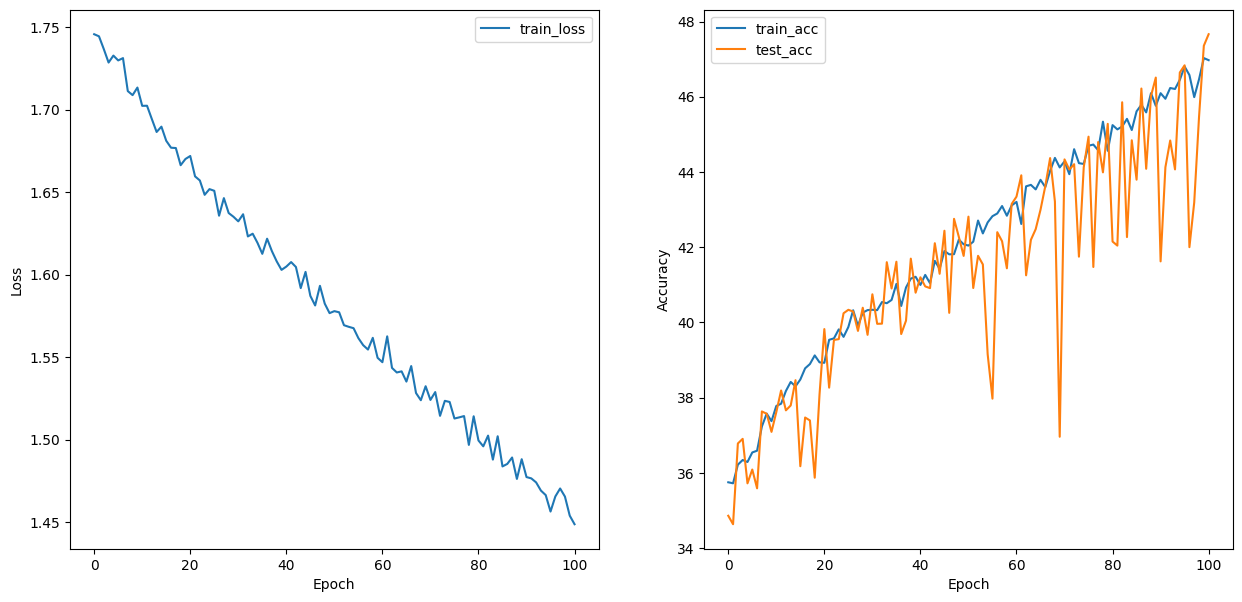

149 50.904852653036315
145 50.008370590209964


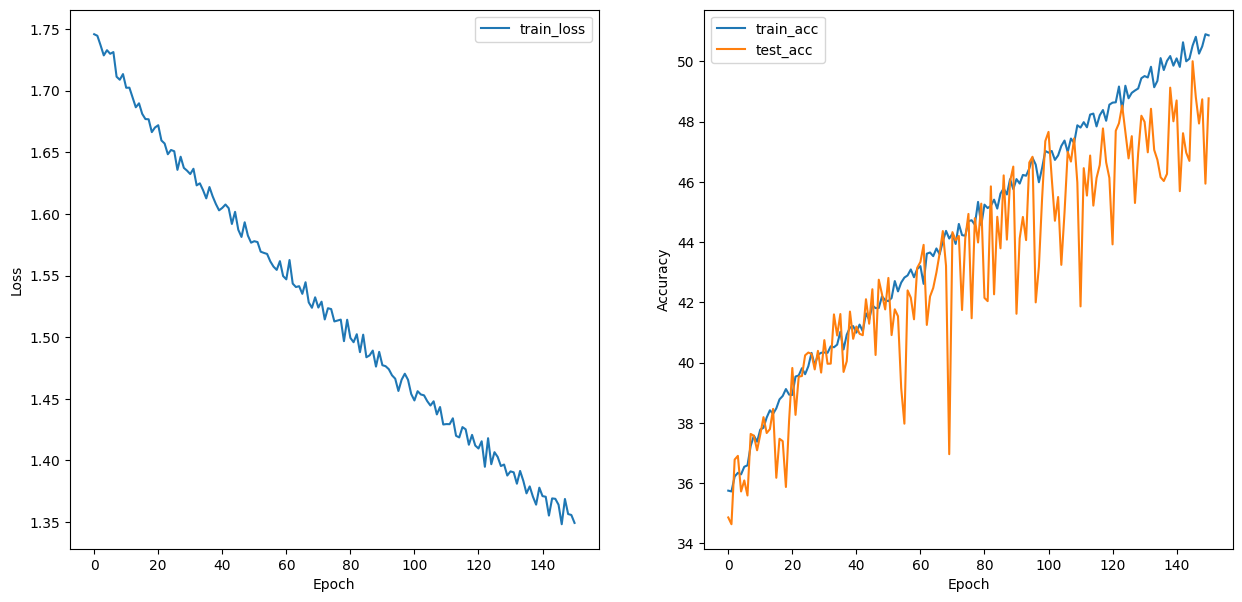

198 54.35038477060746
200 51.446707534790036


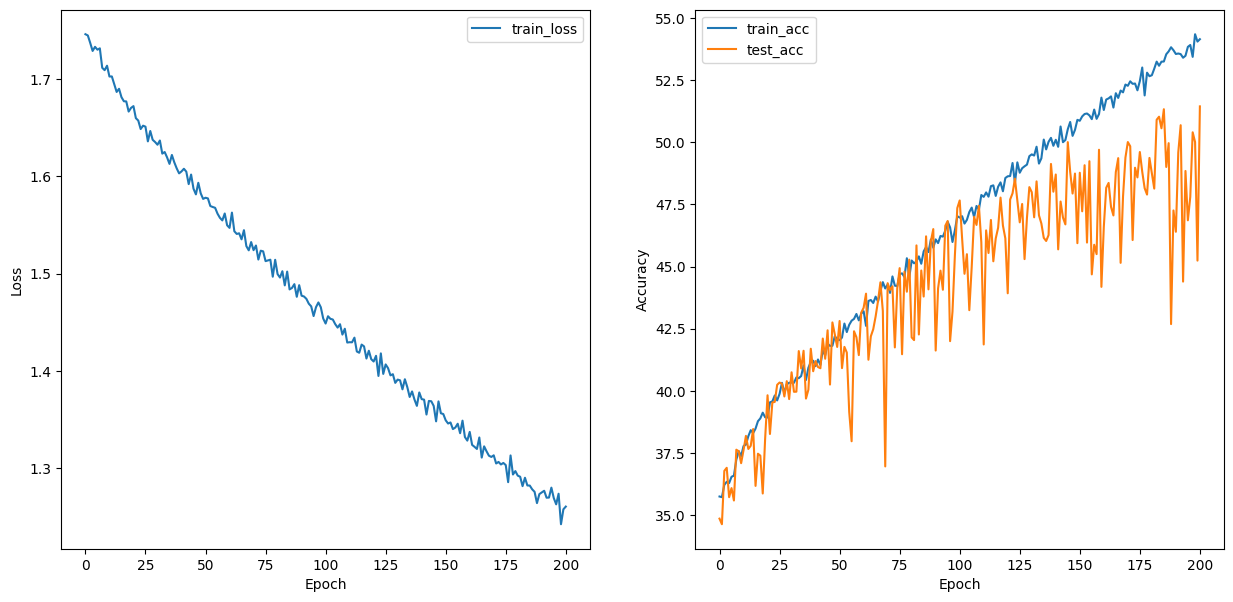

248 57.842244362344545
231 52.611606979370116


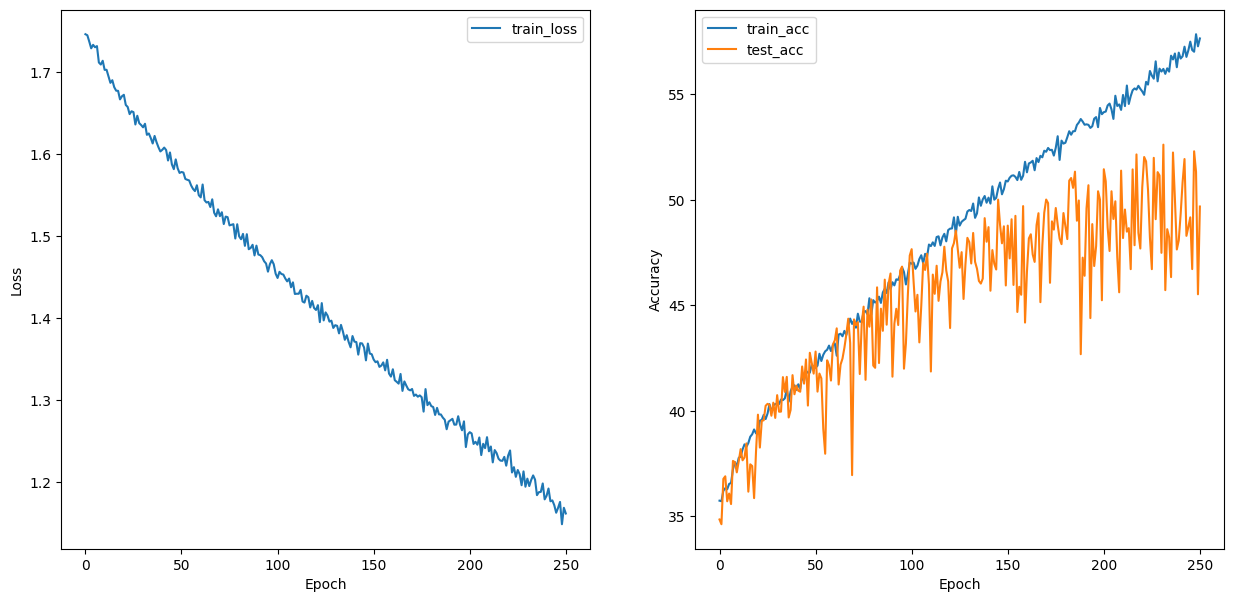

298 61.18647267867108
297 53.38986778259277


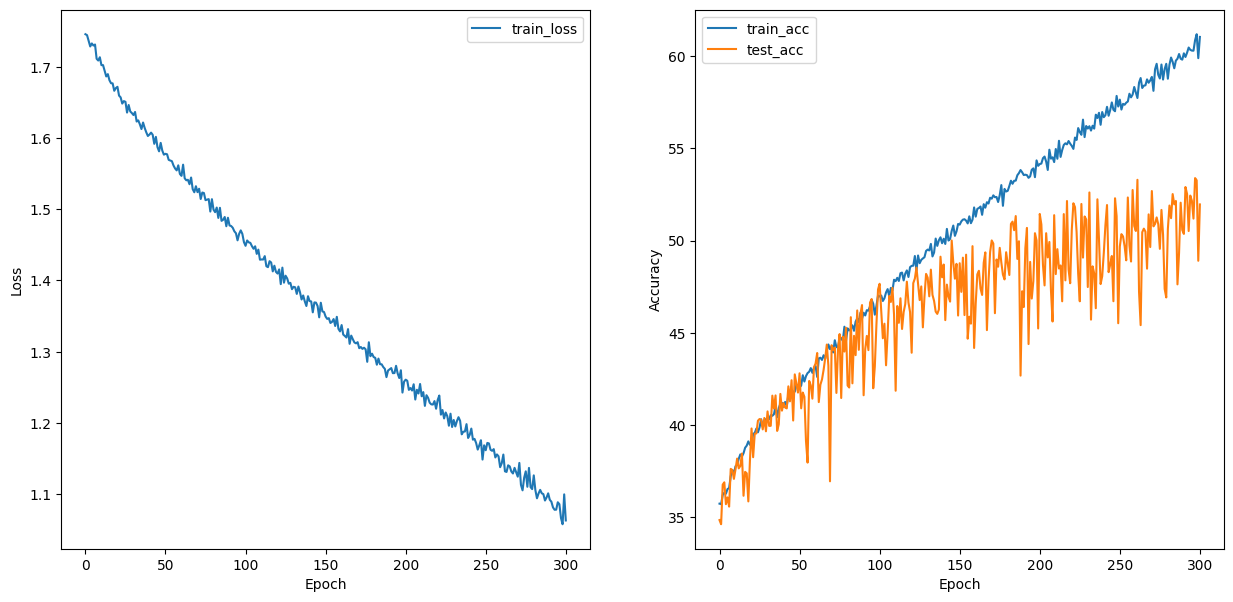

348 64.60350130042251
321 54.17390785217285


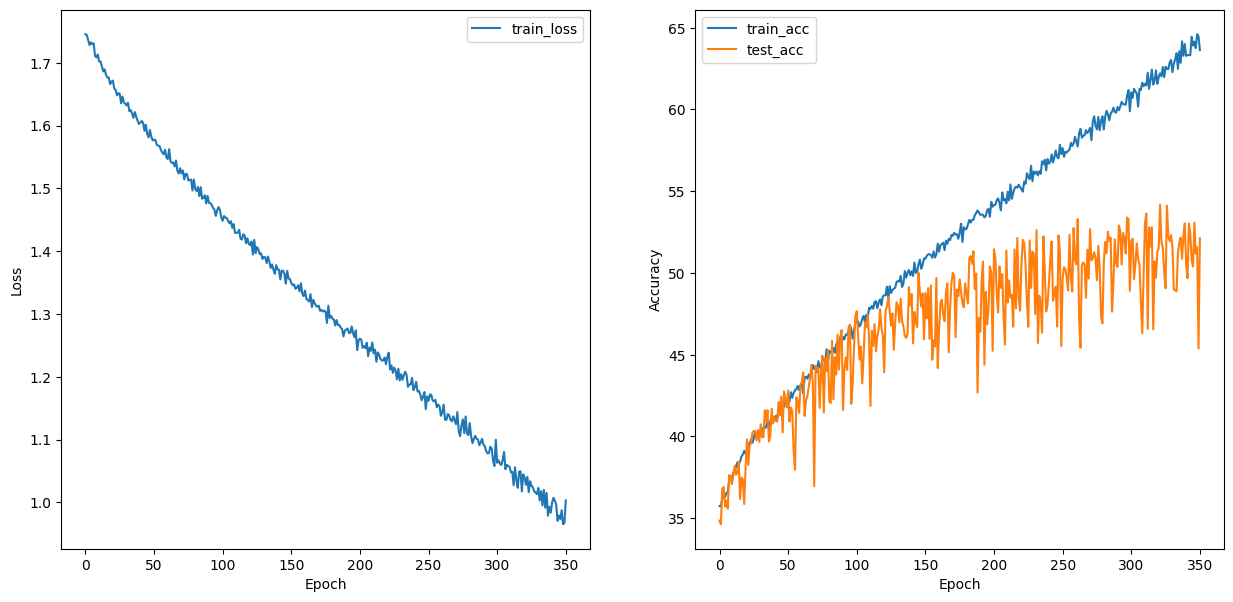

396 68.59353186159717
389 54.57509574890137


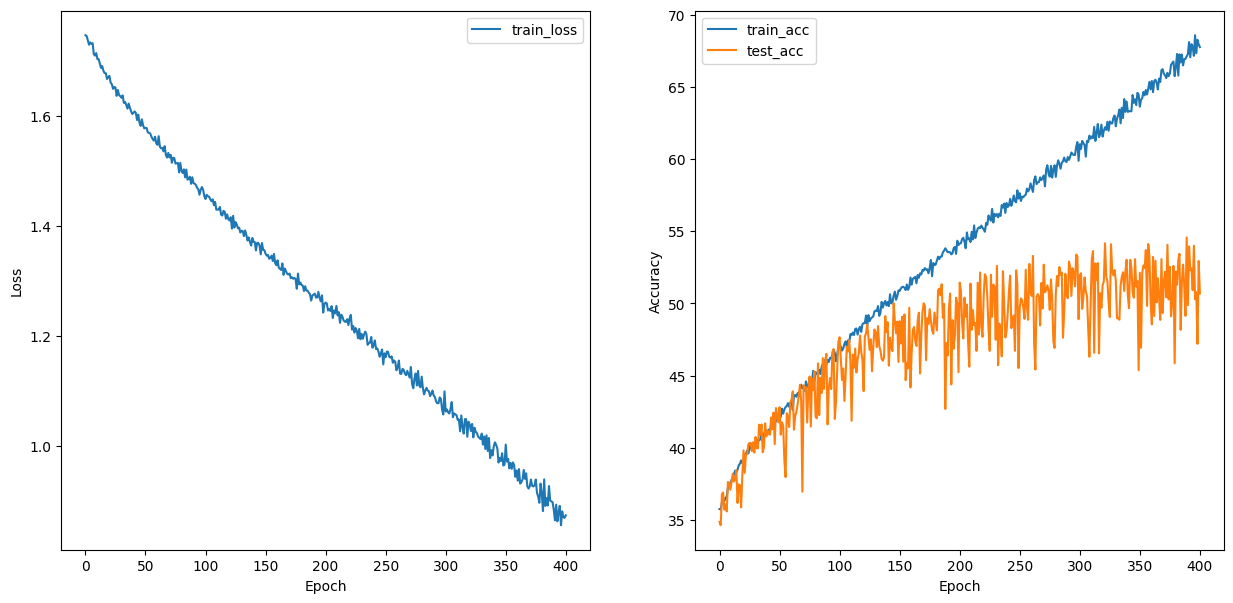

448 73.37974096804248
419 54.801100158691405


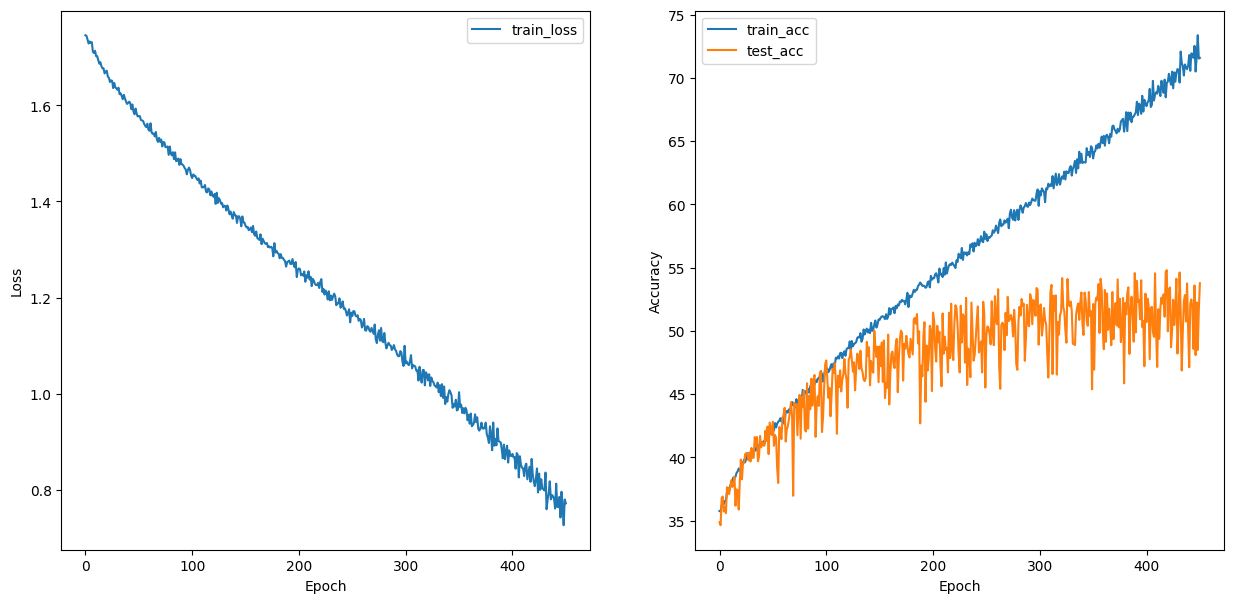

498 77.63367290886082
473 55.274234771728516


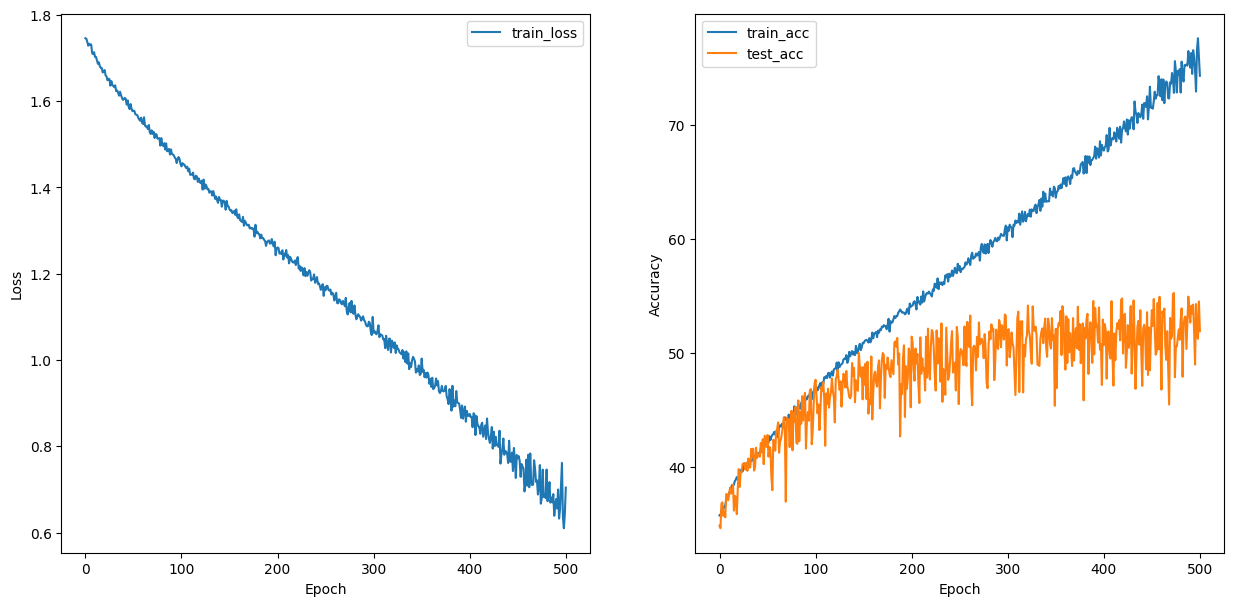

542 81.72865466682278
511 55.32186698913574


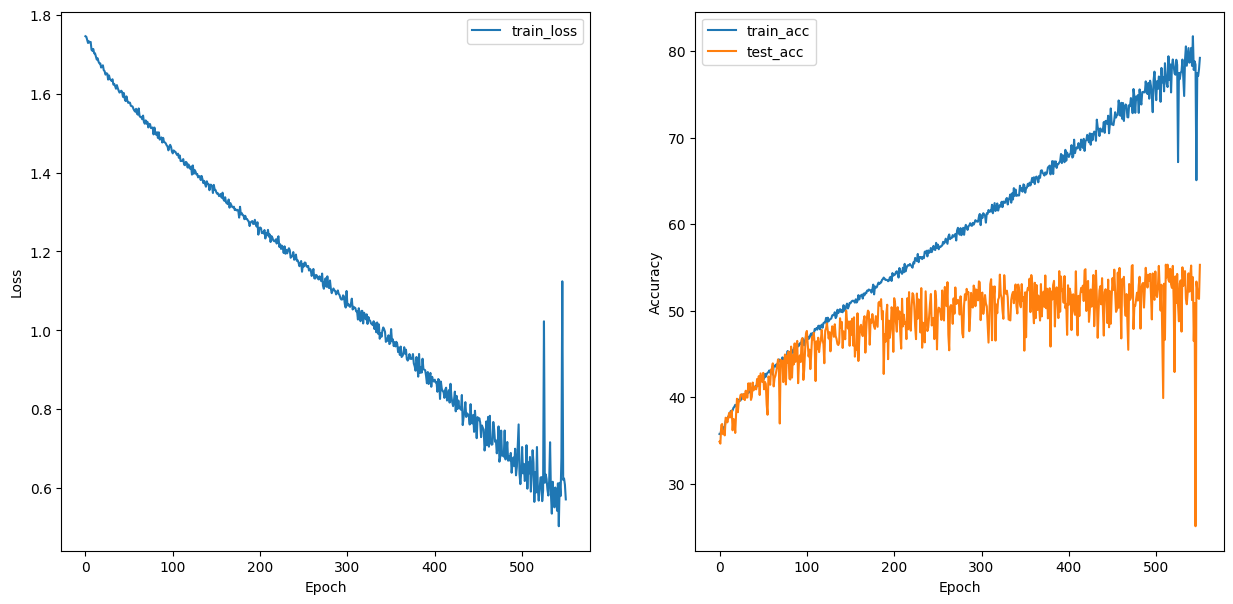

590 87.76348752391581
593 55.83545913696289


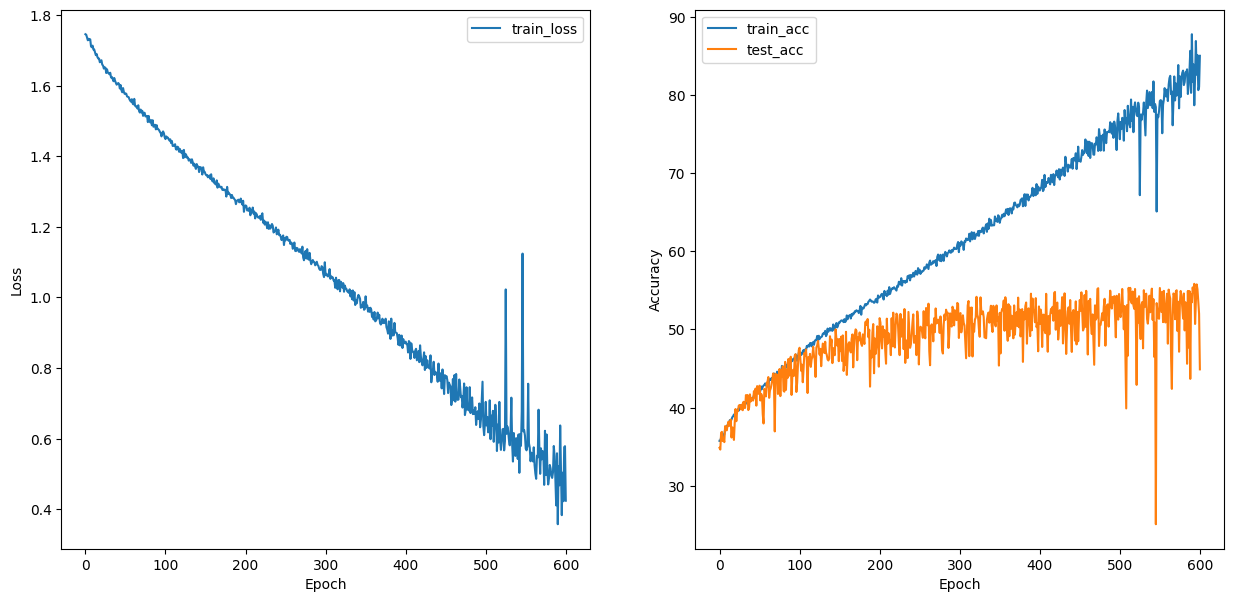

637 90.89518099415059
593 55.83545913696289


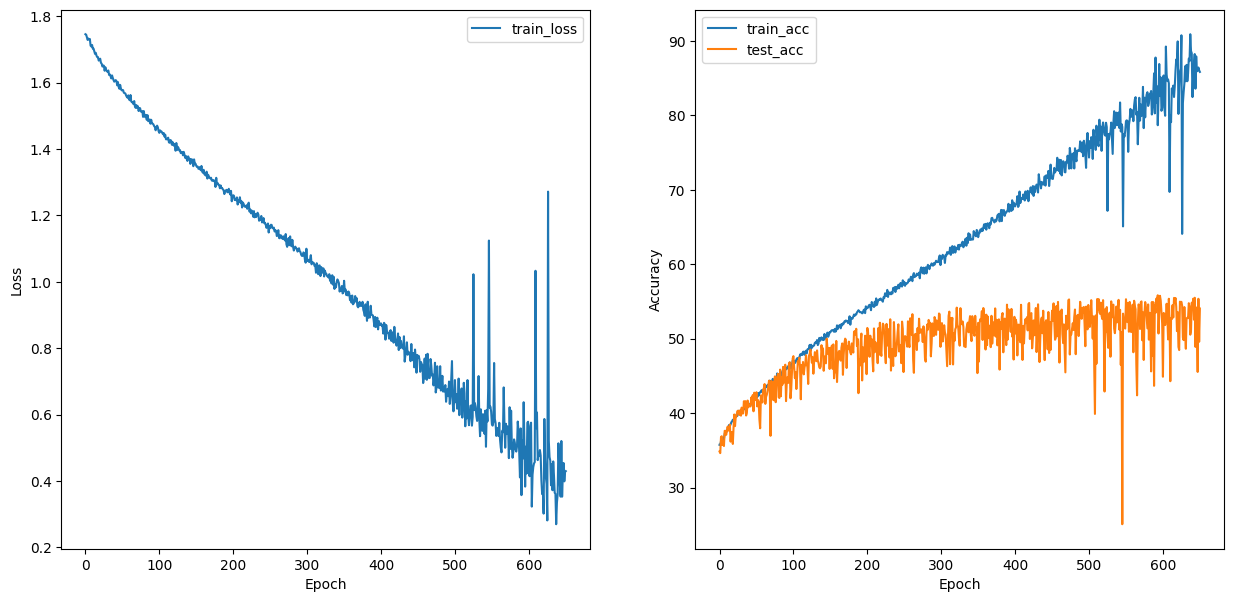

697 95.82834453972019
593 55.83545913696289


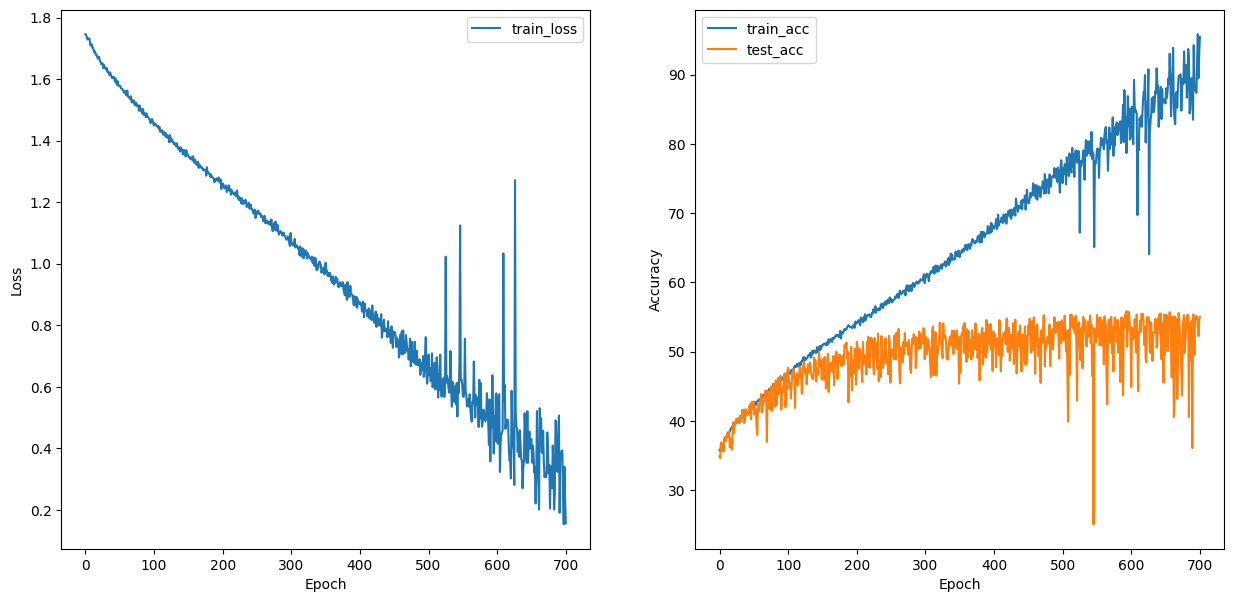

736 97.14882846754425
593 55.83545913696289


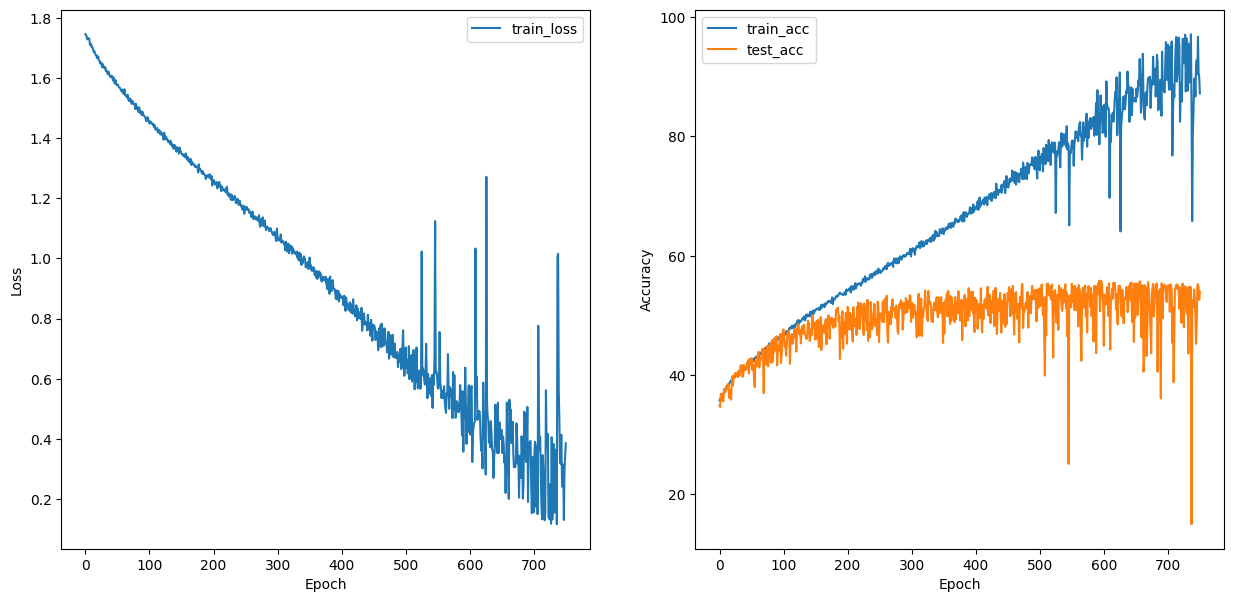

798 99.00053701595384
593 55.83545913696289


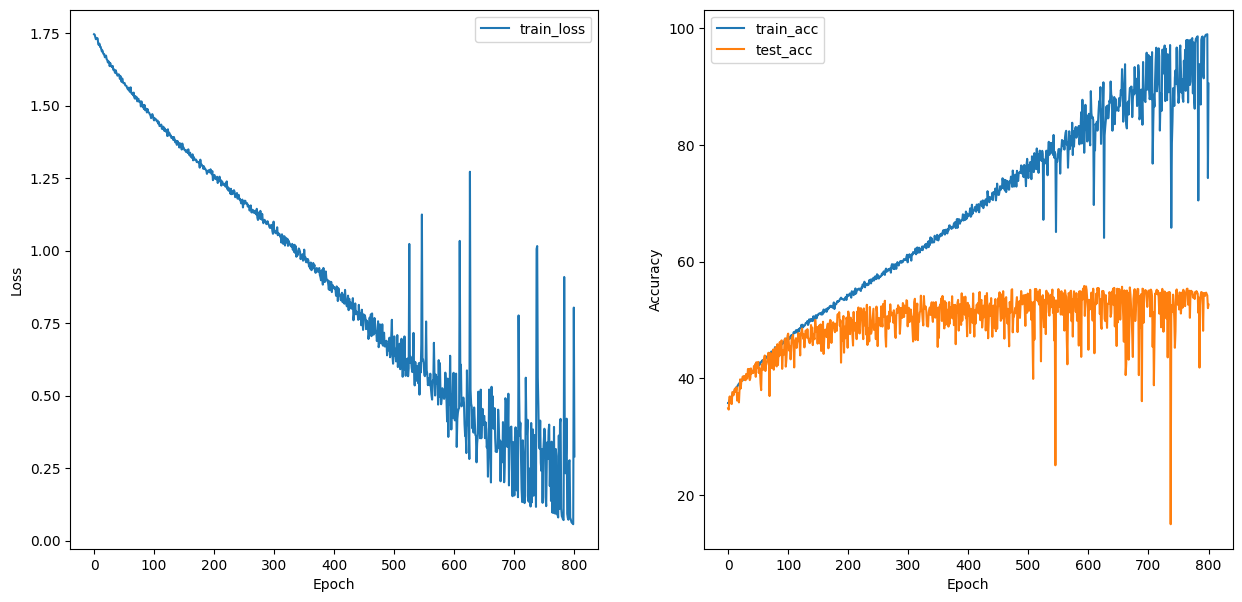

845 99.55507550920758
593 55.83545913696289


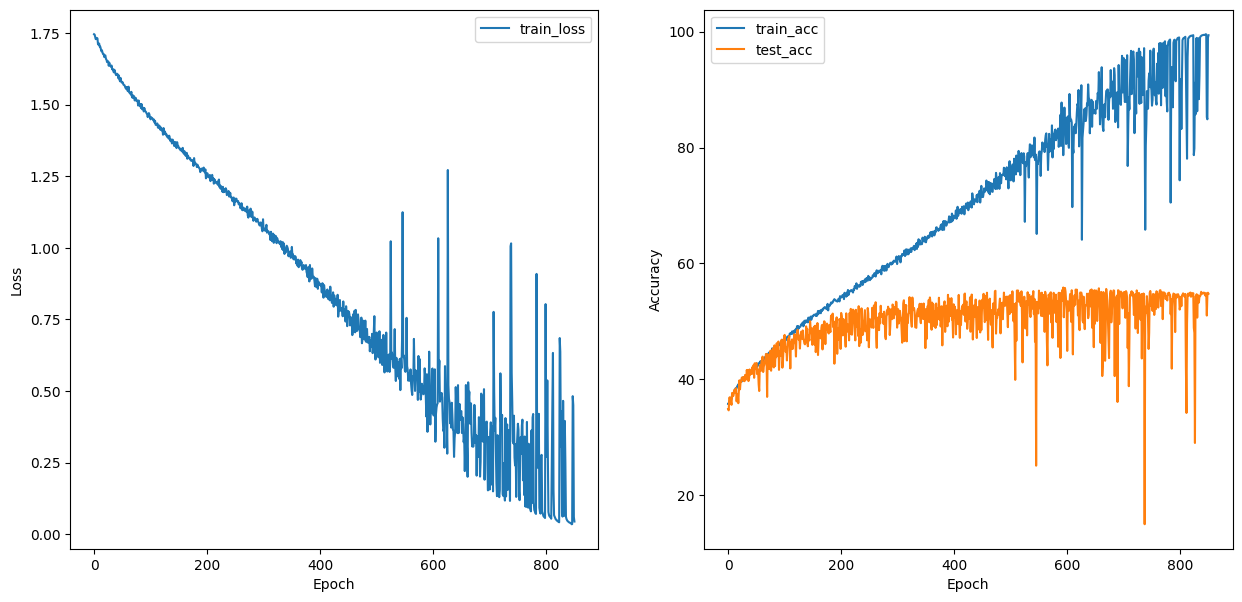

899 99.90632971938776
593 55.83545913696289


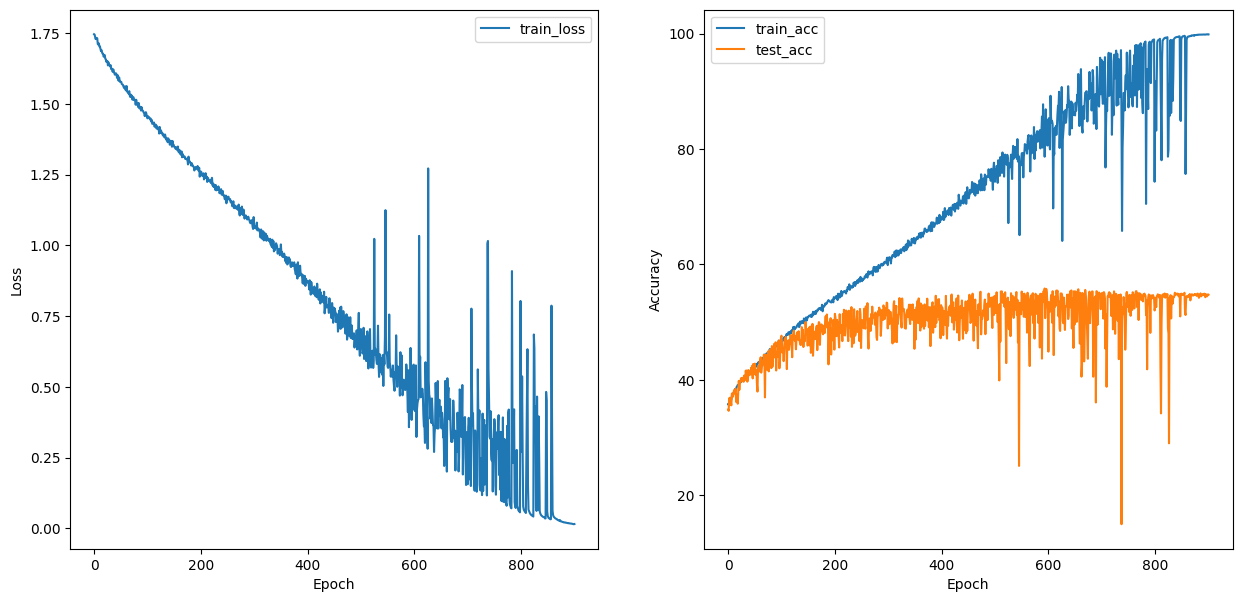

939 99.98804209183673
593 55.83545913696289


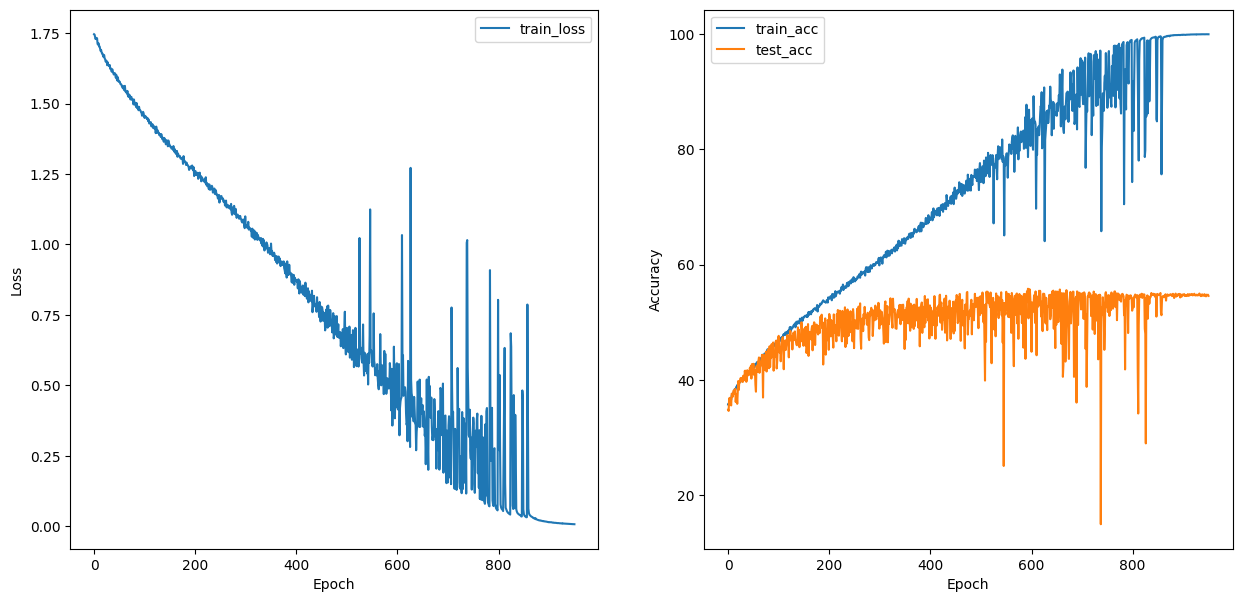

996 100.0
593 55.83545913696289


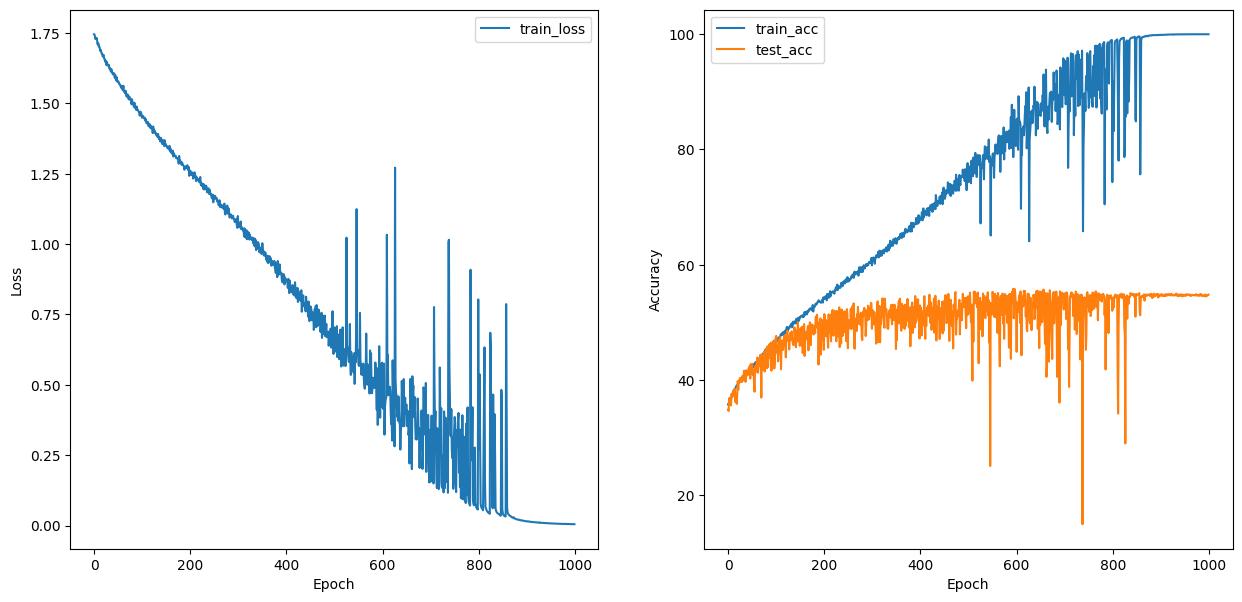

In [17]:
# Hyperparameters
n_epoch = 1000

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# place model and criterion to the device
model = model.to(device)
criterion = criterion.to(device)

train_loss = []
train_acc = []
test_acc = []

for epoch in range(n_epoch):
    train_epoch_loss, train_epoch_acc = train(trainloader, model, criterion, optimizer, device)
    test_epoch_acc = test(testloader, model, device)

    train_loss.append(train_epoch_loss)
    train_acc.append(train_epoch_acc)
    test_acc.append(test_epoch_acc)
    if epoch % 50 == 0 or epoch == 999:
        print(train_acc.index(max(train_acc)), max(train_acc))
        print(test_acc.index(max(test_acc)), max(test_acc))
        plot_loss_acc(train_loss, train_acc, test_acc)


